# Tableau dynamique et réallocations

In [ ]:
l = [1,3,2]

In [ ]:
l.append(5)

In [ ]:
l

In [ ]:
l.insert(0, 8)

In [ ]:
l

In [ ]:
l.insert(3, 17)

In [ ]:
l

In [ ]:
l =[]
for i in range(10):
    l.append(i)
l

In [ ]:
l =[]
for i in range(10):
    l.insert(0,i)
l

In [ ]:
timeit("l =[]\nfor i in range(1000): \n   l.append(i)")

In [ ]:
timeit("l =[]\nfor i in range(10000): \n   l.append(i)")

In [ ]:
timeit("l =[]\nfor i in range(100000): \n   l.append(i)")

In [ ]:
timeit("l =[]\nfor i in range(1000): \n   l.insert(0,i)")

In [ ]:
timeit("l =[]\nfor i in range(10000): \n   l.insert(0,i)")

In [ ]:
timeit("l =[]\nfor i in range(100000): \n   l.insert(0,i)")

## Implantation d'un tableau dynamique

In [1]:
# Timings stuff 
# TODO: move this in a utility library

def timeit_to_sec(tm):    
    units = [u"s", u"ms", u"μs", u"ns"]
    scaling = [1, 1e3, 1e6, 1e9]
    _, _, _, nb, unit = tm.stats
    return nb/scaling[units.index(unit)]
    
def timesec(expr, repeat = 1):
    return timeit_to_sec( sage.misc.sage_timeit.sage_timeit(expr, globals(), repeat = repeat))
    
def curve(timings, color = "black"):
    return line(timings, color=color, marker = "x")

In [2]:
%%cython
from libc.stdlib cimport malloc, free
cdef class MyArray(object):
    cdef int _realloc_step      # taille des blocs  
    cdef float _realloc_factor  # facteur de croissance de taille
    cdef int _size
    cdef int _capacity
    cdef int *_array

    def __cinit__(self):
        self._size = 0
        self._capacity = 1
        self._array = <int *>malloc(sizeof(int) * self._capacity)

    def __init__(self, float realloc_factor, int realloc_step):
        self._realloc_factor = realloc_factor
        self._realloc_step = realloc_step

    cpdef append(MyArray self, int d):
        if self._size >= self._capacity:
            self.newalloc()
        self._array[self._size] = d
        self._size += 1

    cpdef compute_new_capacity(self):
        res = int(self._capacity*self._realloc_factor + 
                  self._realloc_step)
        return max(res, self._size+1)
        
    cpdef newalloc(MyArray self):
        cdef int *new_array
        cdef int i
        self._capacity = self.compute_new_capacity() 
        print("Realloc (capacity = %i)"%self._capacity) 
        new_array = <int *>malloc(sizeof(int) * self._capacity)
        for 0 <= i < self._size:
             new_array[i] = self._array[i]
        free(self._array)
        self._array = new_array

    def __getitem__(MyArray self, int i):
        if 0 <= i < self._size:
            return self._array[i]
        else:
            raise IndexError, "array index out of range"

    def __len__(MyArray self):
        return self._size
    
    def __dealloc__(MyArray self):
        free(self._array)


In [5]:
ar = MyArray(1., 10)

In [6]:
ar

In [7]:
list(ar)

[]

In [8]:
ar.append(12)

In [9]:
ar

In [10]:
list(ar)

[12]

In [11]:
ar.append(7)

Realloc (capacity = 11)


In [12]:
list(ar)

[12, 7]

In [13]:
ar.append(8)

In [14]:
list(ar)

[12, 7, 8]

In [15]:
for i in range(100): ar.append(i^2)

Realloc (capacity = 21)
Realloc (capacity = 31)
Realloc (capacity = 41)
Realloc (capacity = 51)
Realloc (capacity = 61)
Realloc (capacity = 71)
Realloc (capacity = 81)
Realloc (capacity = 91)
Realloc (capacity = 101)
Realloc (capacity = 111)


In [16]:
list(ar)

[12,
 7,
 8,
 0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361,
 400,
 441,
 484,
 529,
 576,
 625,
 676,
 729,
 784,
 841,
 900,
 961,
 1024,
 1089,
 1156,
 1225,
 1296,
 1369,
 1444,
 1521,
 1600,
 1681,
 1764,
 1849,
 1936,
 2025,
 2116,
 2209,
 2304,
 2401,
 2500,
 2601,
 2704,
 2809,
 2916,
 3025,
 3136,
 3249,
 3364,
 3481,
 3600,
 3721,
 3844,
 3969,
 4096,
 4225,
 4356,
 4489,
 4624,
 4761,
 4900,
 5041,
 5184,
 5329,
 5476,
 5625,
 5776,
 5929,
 6084,
 6241,
 6400,
 6561,
 6724,
 6889,
 7056,
 7225,
 7396,
 7569,
 7744,
 7921,
 8100,
 8281,
 8464,
 8649,
 8836,
 9025,
 9216,
 9409,
 9604,
 9801]

In [18]:
l = [100, 200, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 200000, 400000]

In [ ]:
l

In [19]:
l_1 = [(n, timesec("a = MyArray(1., 1)\nfor i in range(%i): a.append(i)"""%n)) for n in l if n <= 25000]
print("Constant 1")
l_20 = [(n, timesec("a = MyArray(1., 20)\nfor i in range(%i): a.append(i)"%n)) for n in l if n <= 100000]
print("Constant 20")
l_100 = [(n, timesec("a = MyArray(1., 100)\nfor i in range(%i): a.append(i)"%n)) for n in l if n <= 200000]
print("Constant 100")
l01 = [(n, timesec("a = MyArray(1.01, 0)\nfor i in range(%i): a.append(i)"%n)) for n in l]
print("Proportional 1%")
l1 = [(n, timesec("a = MyArray(1.1, 0)\nfor i in range(%i): a.append(i)"%n)) for n in l]
print("Proportional 10%")
l5 = [(n, timesec("a = MyArray(1.5, 0)\nfor i in range(%i): a.append(i)"%n)) for n in l]
print("Proportional 50%")
l2 = [(n, timesec("a = MyArray(2., 0)\nfor i in range(%i): a.append(i)"%n)) for n in l]
print("Proportional *2")

Constant 1
Constant 20
Constant 100
Proportional 1%
Proportional 10%
Proportional 50%
Proportional *2


In [20]:
def curve(timings, color = "black", name = ""):
    return line(timings, color=color, marker = "x") + point(timings[-1], color = color, legend_label = name)

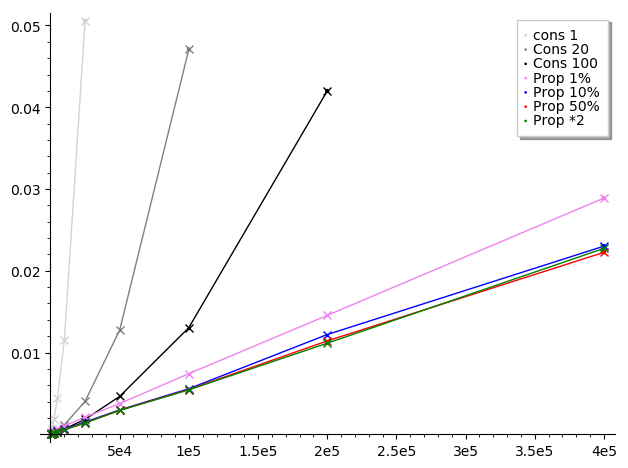

In [21]:
( curve(l_1,   "lightgray",   "cons 1") +
  curve(l_20,  "gray",   "Cons 20") + 
  curve(l_100, "black",  "Cons 100") + 
  curve(l01,   "violet", "Prop 1%") + 
  curve(l1,    "blue",   "Prop 10%") + 
  curve(l5,    "red",    "Prop 50%") + 
  curve(l2,    "green",  "Prop *2")).show()

In [22]:
lg_1 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l_1]
lg_20 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l_20]
lg_100 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l_100]
lg01 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l01]
lg1 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l1]
lg5 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l5]
lg2 = [(log(x)/log(10), log(y)/log(10)) for (x, y) in l2]

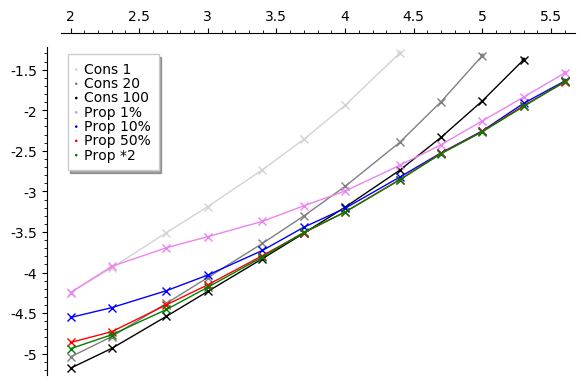

In [23]:
( curve(lg_1,   "lightgray", "Cons 1") + 
  curve(lg_20,  "gray",      "Cons 20") + 
  curve(lg_100, "black",     "Cons 100") + 
  curve(lg01,   "violet",    "Prop 1%") + 
  curve(lg1,    "blue",      "Prop 10%") + 
  curve(lg5,    "red",       "Prop 50%") + 
  curve(lg2,    "green",     "Prop *2")).show()

In [ ]:
from datetime import datetime, date, time

In [ ]:
before = datetime.now() 
after = datetime.now()
delta = after - before
delta

In [ ]:
delta.microseconds

In [ ]:
after = datetime.now()
delta = after - before
delta

In [ ]:
delta.microseconds

In [ ]:
delta.seconds + delta.microseconds*1e-6

In [ ]:
l = []
timings = [(0,0)]
debut = datetime.now()
for i in range(1, 21):
    for j in range(5000):
        # l.append(i)
        l.insert(0,i)
    fin = datetime.now()
    delta = fin - debut
    timings.append((5000*i, delta.seconds + delta.microseconds*1e-6))

In [ ]:
len(l)

In [ ]:
timings

In [ ]:
l = []
for i in range(1000000):
    l.append(i)

In [ ]:
len(l)